                                                                                                by Maria

# <center>Predicting Gold Returns Using Relevant Metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 0 Исходные данные
Если возражений нет, то ваша первая задача - разобраться с линейной регрессией и применить этот подход для прогнозирования цены на золото вот из этого датасета (https://www.kaggle.com/datasets/cvergnolle/gold-price-and-relevant-metrics). Вам необходимо спрогнозировать следующее:

1. Какая была цена на золото 20 декабря 2021 года и сравнить с историческими данными.
2. Также спрогнозировать, какая цена была на золото 8 августа 2024 года и сравнить с историческими данными.
3. Спрогнозировать цену для 30 сентября 2024 года и мы с вами в понедельник вместе оценим, насколько хорошо работает ваша модель для столь отдалённой даты. А также обсудим возможные причины отклонения предсказаний от реальных данных и методы улучшения работы модели.

# 1. EDA (Exploratory Data Analysis)

In [2]:
data = pd.read_csv('Gold Price Prediction.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data.set_index('Date', inplace=True)

data.head(15)

,Price 2 Days Prior,Price 1 Day Prior,Price Today,Price Tomorrow,Price Change Tomorrow,Price Change Ten,Std Dev 10,Twenty Moving Average,Fifty Day Moving Average,200 Day Moving Average,Monthly Inflation Rate,EFFR Rate,Volume,Treasury Par Yield Month,Treasury Par Yield Two Year,Treasury Par Yield Curve Rates (10 Yr),DXY,SP Open,VIX,Crude
Date,,,,,,,,,,,,,,,,,,,,
2024-08-07,2405.87,2384.90,2385.83,NaN,NaN,NaN,30.155078,2414.7450,2368.2948,2189.80780,3.0,5.33,96,5.50,4.00,3.96,103.37,5293.13,24.77,72.84
2024-08-06,2442.74,2405.87,2384.90,2385.83,0.93,NaN,29.423936,2414.1525,2367.7916,2187.85630,3.0,5.33,89,5.50,3.99,3.90,102.78,5206.42,33.71,73.86
2024-08-05,2447.17,2442.74,2405.87,2384.90,-20.97,NaN,28.341301,2413.2305,2367.1584,2185.96345,3.0,5.33,86,5.52,3.89,3.78,103.22,5151.14,23.39,74.21
2024-08-02,2447.23,2447.17,2442.74,2405.87,-36.87,NaN,28.616661,2411.0920,2365.7250,2183.85640,3.0,5.33,89,5.54,3.88,3.80,104.31,5376.63,20.52,76.87
2024-08-01,2411.09,2447.23,2447.17,2442.74,-4.43,NaN,26.084796,2408.5670,2363.5624,2181.55785,3.0,5.33,83,5.55,4.16,3.99,104.07,5537.84,16.20,78.59
2024-07-31,2382.47,2411.09,2447.23,2447.17,-0.06,NaN,25.307192,2404.1030,2362.2836,2179.18645,3.0,5.33,78,5.49,4.29,4.09,104.43,5505.59,16.66,75.24
2024-07-30,2387.11,2382.47,2411.09,2447.23,36.14,NaN,28.431801,2399.7615,2361.7958,2176.81845,3.0,5.33,87,5.50,4.35,4.15,104.56,5478.73,16.64,75.91
2024-07-29,2365.37,2387.11,2382.47,2411.09,28.62,NaN,34.908633,2395.7900,2362.1302,2174.66915,3.0,5.33,90,5.50,4.36,4.17,104.33,5476.55,16.59,77.30
2024-07-26,2400.12,2365.37,2387.11,2382.47,-4.64,NaN,33.472691,2393.3445,2362.7596,2172.64085,3.0,5.33,85,5.49,4.36,4.20,104.36,5433.67,17.97,78.35


In [3]:
# по выходным данных нет - биржа не работает
# соответственно скачок с пт на пн - более резкий - в мире перемены
# заметим, что Price Change Ten - считается на 10 дней вперед
# а вот Std dev 10 - на 10 дней назад (хорошо бы проверить, по какой формуле считается) 
# по Monthly Inflation Rate стоит посмотреть общую тенденцию (тренд) и кол-во уникальных значений 
#и где они меняются
#EFFR - аналогично
#см масштаб признаков - что-то в 1цах, что-то в млрд долларов

#+априорная связь признаков - буду искать корреляцию

нашёлся лишний пробел!!! правим

In [4]:
data.rename(columns={'Volume ': 'Volume'}, inplace=True)

## 1.1. Анализ признакового пространства

In [7]:
from googletrans import Translator, LANGUAGES

AttributeError: module 'httpcore' has no attribute 'SyncHTTPTransport'

In [ ]:
translator = Translator()

In [ ]:
info_data = {
    'Признак': [],
    'Описание на русском': [],
    'Подробнее': [],
    'Примечание': []
}

wiki_links = {
    'Std Dev 10' : 'https://ru.wikipedia.org/wiki/Среднеквадратическое_отклонение',
    'Treasury Par Yield Month' : 'https://www.investopedia.com/terms/p/par-yield-curve.asp',
    'Treasury Par Yield Two Year' : 'https://www.investopedia.com/terms/p/par-yield-curve.asp',
    'Treasury Par Yield Curve Rates (10 Yr)' : 'https://www.investopedia.com/terms/p/par-yield-curve.asp',
    'EFFR Rate' : 'https://en.wikipedia.org/wiki/Federal_funds_rate',
    'VIX' : 'https://en.wikipedia.org/wiki/VIX',
    'SP Open' : 'https://en.wikipedia.org/wiki/S%26P_Global',
    'DXY' : 'https://en.wikipedia.org/wiki/U.S._Dollar_Index',
    'Monthly Inflation Rate' : 'https://en.wikipedia.org/wiki/Inflation',
    'Twenty Moving Average' : 'https://ru.wikipedia.org/wiki/Скользящая_средняя',
    'Fifty Day Moving Average' : 'https://ru.wikipedia.org/wiki/Скользящая_средняя',
    '200 Day Moving Average' : 'https://ru.wikipedia.org/wiki/Скользящая_средняя'
}

kaggle_about = {
    'Price 2 Days Prior' : 'Price of gold 2 days before date', 
    'Price 1 Day Prior' : 'Price of gold 1 day before date',
    'Price Today' : 'Price of Gold at respective date',
    'Price Tomorrow' : 'Price of Gold Tomorrow',
    'Price Change Tomorrow' : 'Change in price between present price and tomorrow’s price',
    'Price Change Ten' : 'Change in price between present price and price 10 days from now',
    'Std Dev 10' : 'The standard deviation of gold prices in last 10 days',
    'Twenty Moving Average' : 'Moving average of gold price in last 20 days. Calculated by summing the price of gold in over that span of time and dividing by the number of days.',
    'Fifty Day Moving Average' : 'Moving average of gold price in last 50 days. Calculated by summing the price of gold in over that span of time and dividing by the number of days.',
    '200 Day Moving Average' : 'Moving average of gold price in last 200 days. Calculated by summing the price of gold in over that span of time and dividing by the number of days.',
    'Monthly Inflation Rate' : 'Historical inflation rate by month, assuming no change in inflation from June 2024 - present.',
    'EFFR Rate' : 'Effective federal funds rate - Current interest rate set by the Fed',
    'Volume' : 'Total amount of overnight loans taking place at the Fed, recorded in Billions',
    'Treasury Par Yield Month' : 'Yields on 1-month U.S. Treasury Bonds',
    'Treasury Par Yield Two Year' : 'Yields on 2-year U.S. Treasury Bonds',
    'Treasury Par Yield Curve Rates (10 Yr)' : 'Yields on 10-year U.S. Treasury Bonds',
    'DXY' : 'Price of US Dollar Index, showing the strength of USD in relation to other currencies',
    'SP Open' : 'Opening price of S&P 500',
    'VIX' : 'Opening price of VIX (Volatility Index)',
    'Crude' : 'Opening price of Crude Oil (CL=F)'
}

for key in kaggle_about.keys():
    kaggle_about[key] = translator.translate(kaggle_about.get(key), src='en', dest='ru').text

for column in data.columns:
    translated_text = translator.translate(column, src='en', dest='ru').text
    info_data['Признак'].append(column)
    info_data['Описание на русском'].append(translated_text)
    info_data['Подробнее'].append(wiki_links.get(column, ''))
    info_data['Примечание'].append(kaggle_about.get(column, ''))
    
info_data['Описание на русском'][5] = 'Изменение цены за десять дней'
info_data['Описание на русском'][7] = '10 -дневная скользящая средняя'
info_data['Описание на русском'][8] = '50 -дневная скользящая средняя'
info_data['Описание на русском'][13] = 'Казначейская доходность за месяц'
info_data['Описание на русском'][14] = 'Казначейская доходность за 2 года'
info_data['Описание на русском'][15] = 'Казначейская доходность за 10 лет'
info_data['Описание на русском'][18] = 'Индекс волатильности'
info_data['Описание на русском'][19] = 'Цена открытия сырой нефти'
info_data['Описание на русском'][17] = 'Цена открытия S&P 500'
info_df = pd.DataFrame(info_data)
translated_text.type()

### Основные выводы

In [8]:
def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'

info_df.style.format({'Подробнее': make_clickable})

NameError: name 'info_df' is not defined

## 1.2. Визуальный анализ признаков

Понаблюдаем изменение признаков на одном общем графике

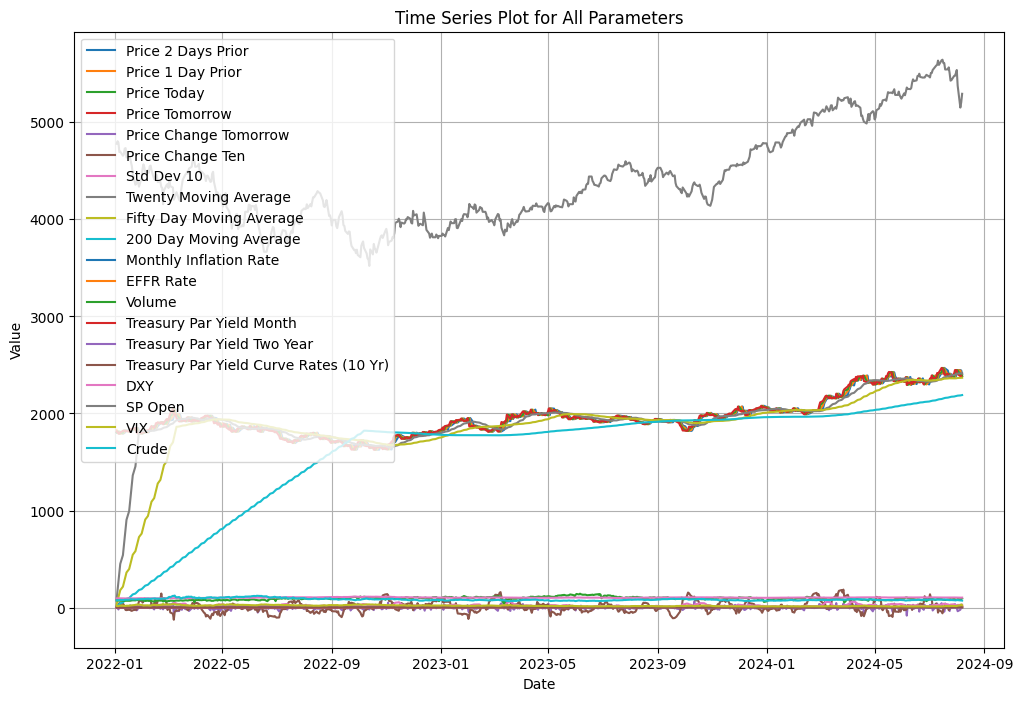

In [9]:
plt.figure(figsize=(12, 8)) 


for column in data.columns:
    plt.plot(data.index, data[column], label=column)

plt.title('Time Series Plot for All Parameters') 
plt.xlabel('Date')  
plt.ylabel('Value')  
plt.legend()  
plt.grid(True)  
plt.show()

Понаблюдаем изменение признаков по-отдельности

In [10]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

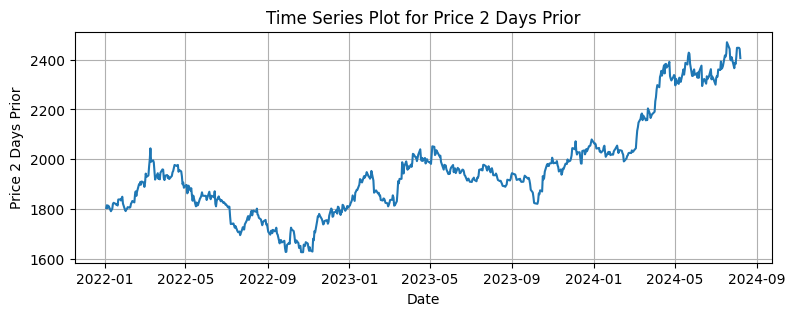

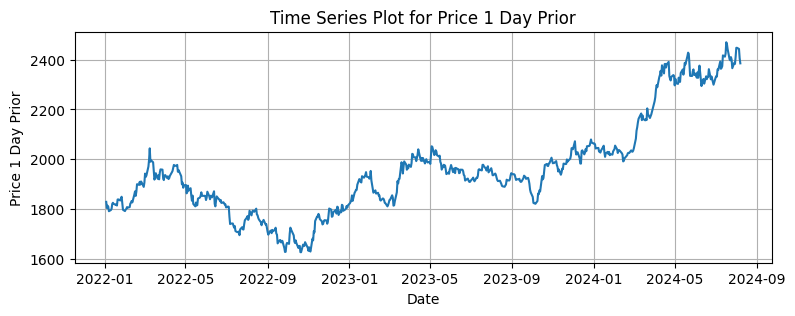

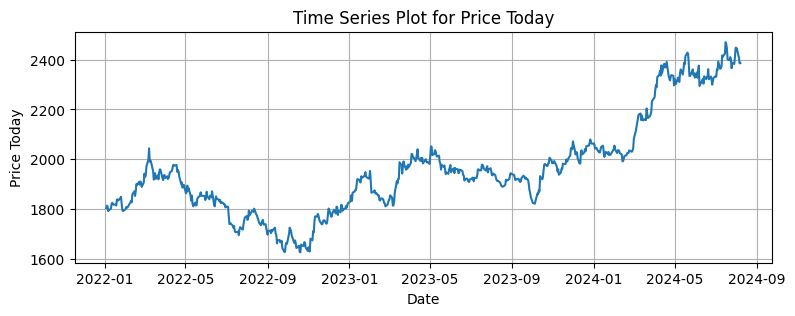

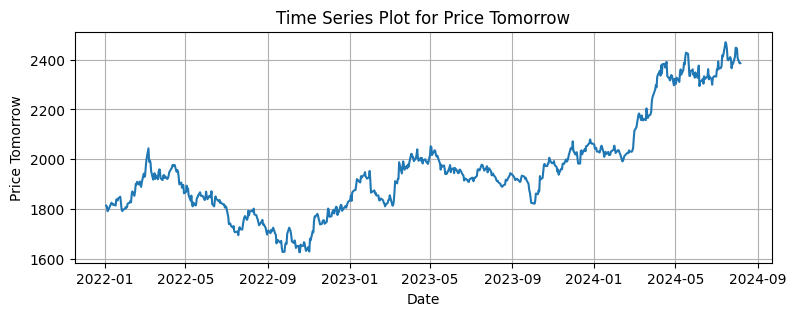

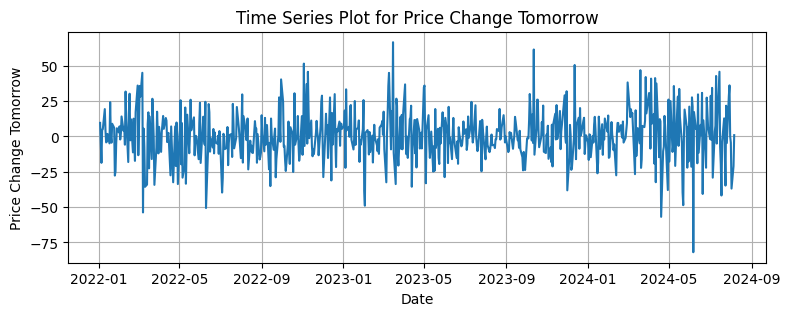

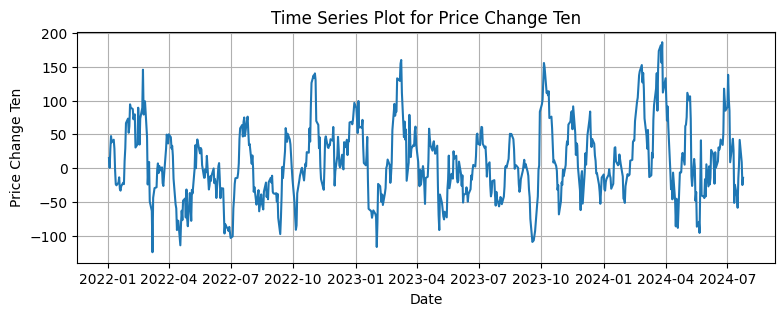

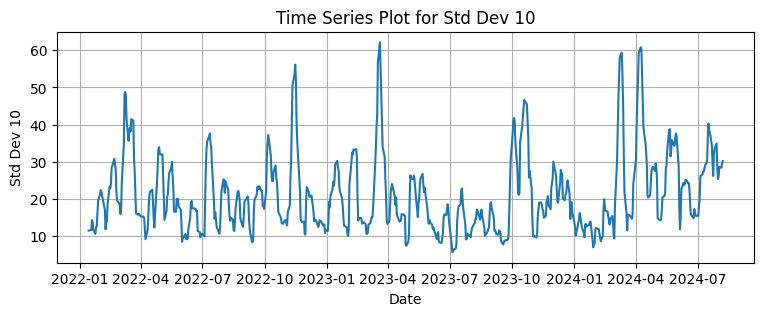

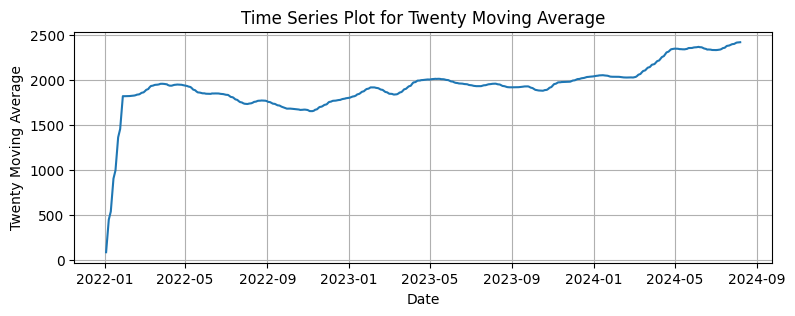

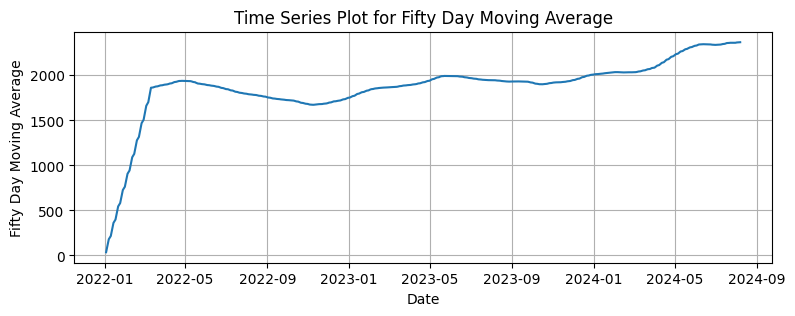

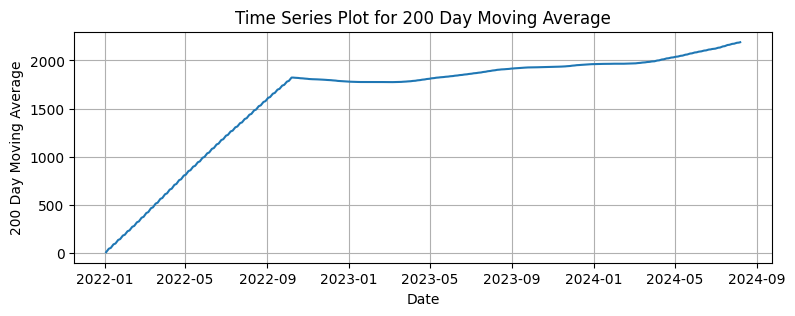

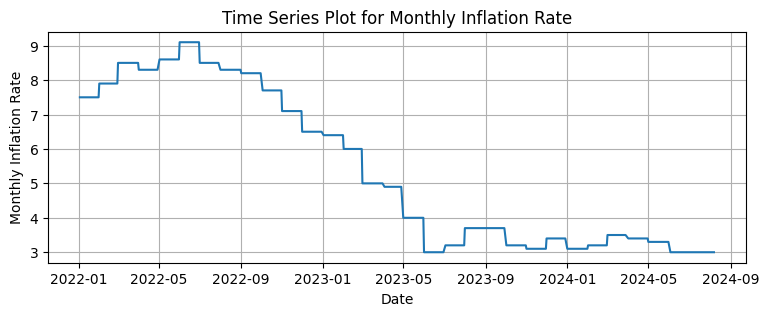

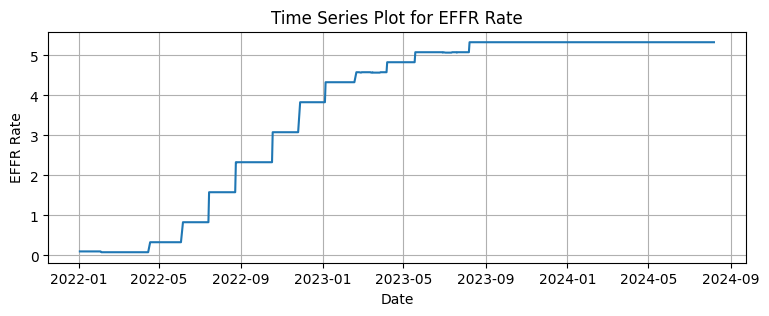

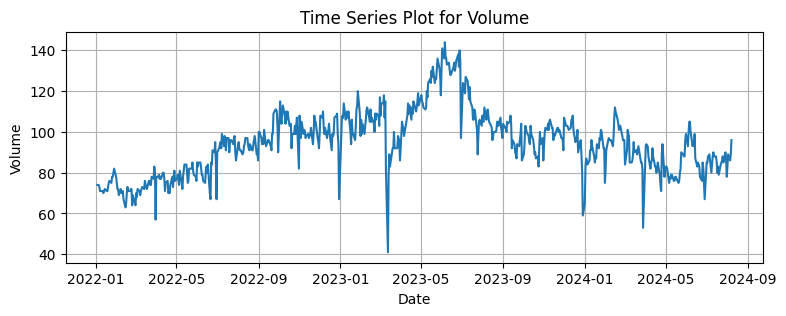

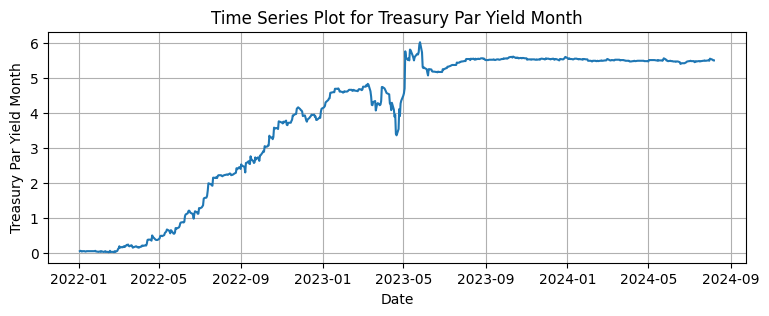

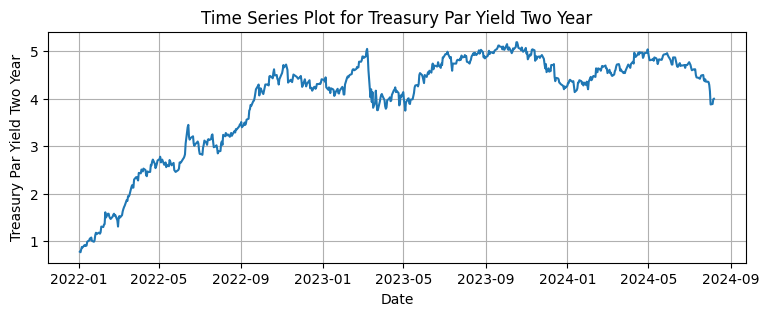

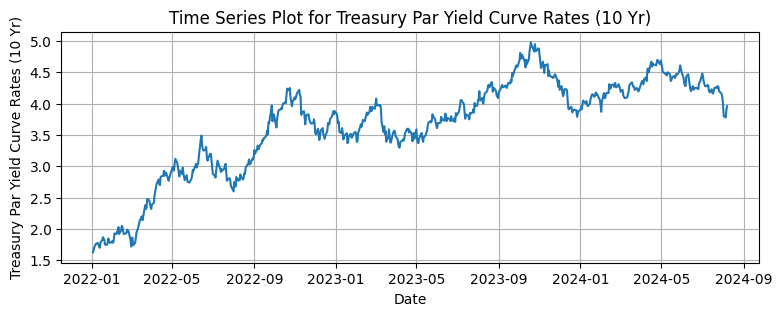

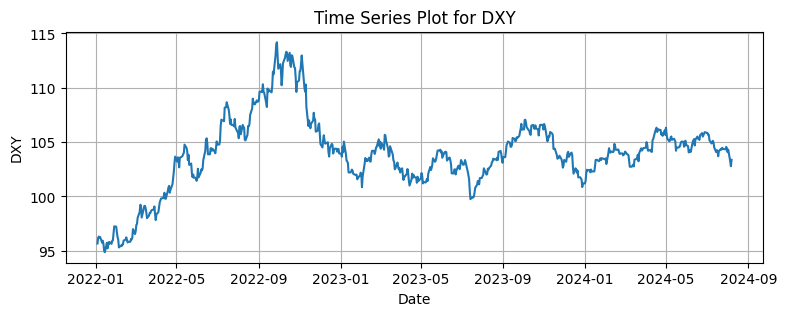

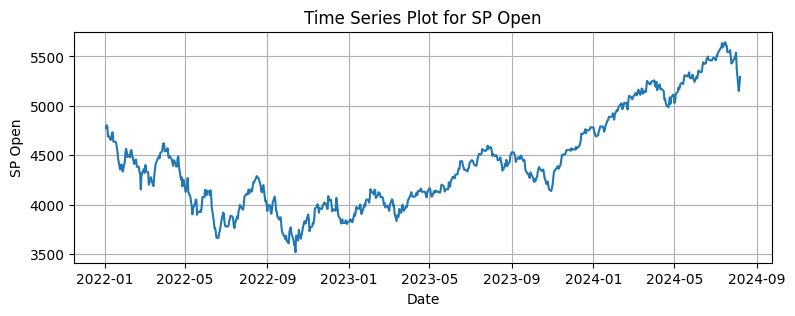

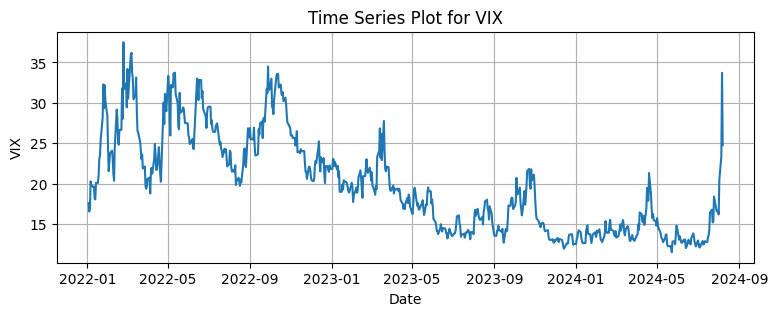

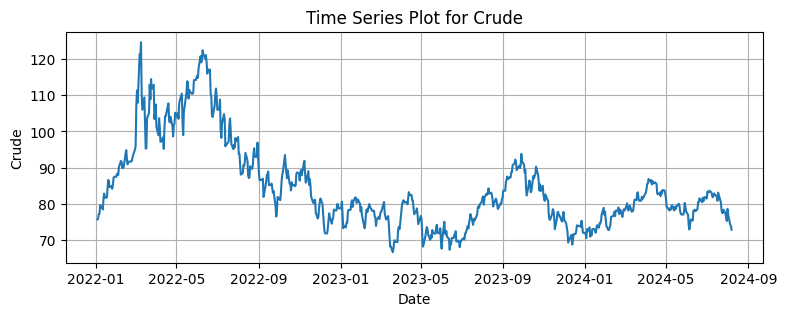

In [11]:
for column in data.columns:
    plt.figure(figsize=(9, 3))  
    plt.plot(data.index, data[column])  
    plt.title(f'Time Series Plot for {column}') 
    plt.xlabel('Date')  
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

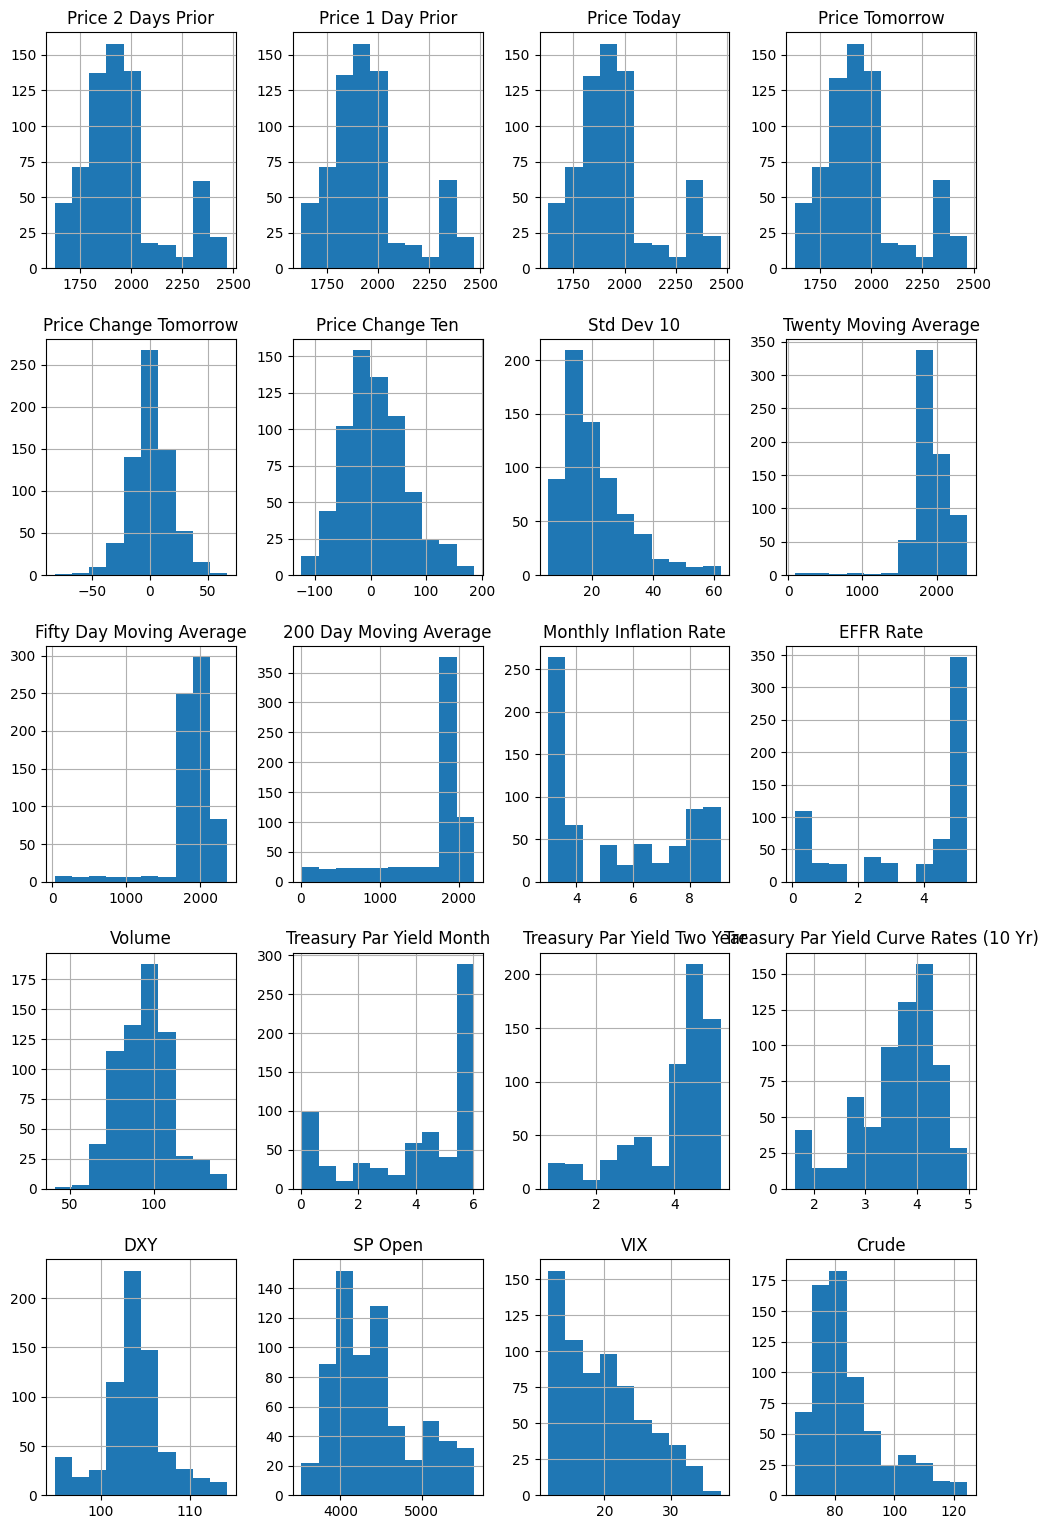

In [12]:
data.hist(figsize=(12, 19));

### Основные выводы: 
на основании масштабов данных и их распределений далее будем провдить нормировки

## 1.3. Посмотрим на скоррелированность данных

In [13]:
corr = abs(data.corr())
corr

,Price 2 Days Prior,Price 1 Day Prior,Price Today,Price Tomorrow,Price Change Tomorrow,Price Change Ten,Std Dev 10,Twenty Moving Average,Fifty Day Moving Average,200 Day Moving Average,Monthly Inflation Rate,EFFR Rate,Volume,Treasury Par Yield Month,Treasury Par Yield Two Year,Treasury Par Yield Curve Rates (10 Yr),DXY,SP Open,VIX,Crude
Price 2 Days Prior,1.000000,0.995882,0.992064,0.988666,0.002540,0.016219,0.246372,0.754456,0.595086,0.405514,0.676926,0.534565,0.166250,0.500229,0.340361,0.444328,0.169621,0.876876,0.611316,0.283200
Price 1 Day Prior,0.995882,1.000000,0.995910,0.992051,0.007727,0.016213,0.254211,0.751132,0.591461,0.405843,0.678687,0.536505,0.171321,0.501857,0.339557,0.443513,0.174048,0.879007,0.614443,0.283553
Price Today,0.992064,0.995910,1.000000,0.995919,0.010368,0.017170,0.259093,0.749467,0.589052,0.406959,0.680608,0.538895,0.174374,0.503755,0.339683,0.443558,0.171748,0.880275,0.617251,0.287555
Price Tomorrow,0.988666,0.992051,0.995919,1.000000,0.079917,0.012666,0.257445,0.744929,0.583812,0.405939,0.681857,0.540632,0.177661,0.504877,0.343626,0.446794,0.170609,0.880455,0.624137,0.289602
Price Change Tomorrow,0.002540,0.007727,0.010368,0.079917,1.000000,0.321025,0.010814,0.008127,0.018914,0.020980,0.042779,0.043340,0.032418,0.036344,0.042685,0.047701,0.008527,0.038774,0.040527,0.054256
Price Change Ten,0.016219,0.016213,0.017170,0.012666,0.321025,1.000000,0.008404,0.002816,0.058492,0.082900,0.148006,0.145014,0.001382,0.127733,0.124802,0.147998,0.049365,0.114636,0.105969,0.188887
Std Dev 10,0.246372,0.254211,0.259093,0.257445,0.010814,0.008404,1.000000,0.193874,0.143167,0.036868,0.028123,0.014553,0.207920,0.020250,0.006871,0.070912,0.081560,0.140961,0.124821,0.054738
Twenty Moving Average,0.754456,0.751132,0.749467,0.744929,0.008127,0.002816,0.193874,1.000000,0.878140,0.559295,0.559433,0.539290,0.037261,0.529290,0.514223,0.552579,0.124723,0.561348,0.429342,0.154735
Fifty Day Moving Average,0.595086,0.591461,0.589052,0.583812,0.018914,0.058492,0.143167,0.878140,1.000000,0.718018,0.520504,0.592186,0.208498,0.605196,0.677659,0.680596,0.388844,0.380107,0.409056,0.134369
200 Day Moving Average,0.405514,0.405843,0.406959,0.405939,0.020980,0.082900,0.036868,0.559295,0.718018,1.000000,0.737190,0.910823,0.519699,0.931099,0.956062,0.916554,0.590902,0.274785,0.600261,0.620102


In [14]:
corr = abs(data.drop(['Price 2 Days Prior', 'Price 1 Day Prior', 'Price Tomorrow', 'EFFR Rate', 'Treasury Par Yield Two Year', 'Treasury Par Yield Curve Rates (10 Yr)', 'Fifty Day Moving Average', '200 Day Moving Average', 'Treasury Par Yield Month'], axis=1).corr())

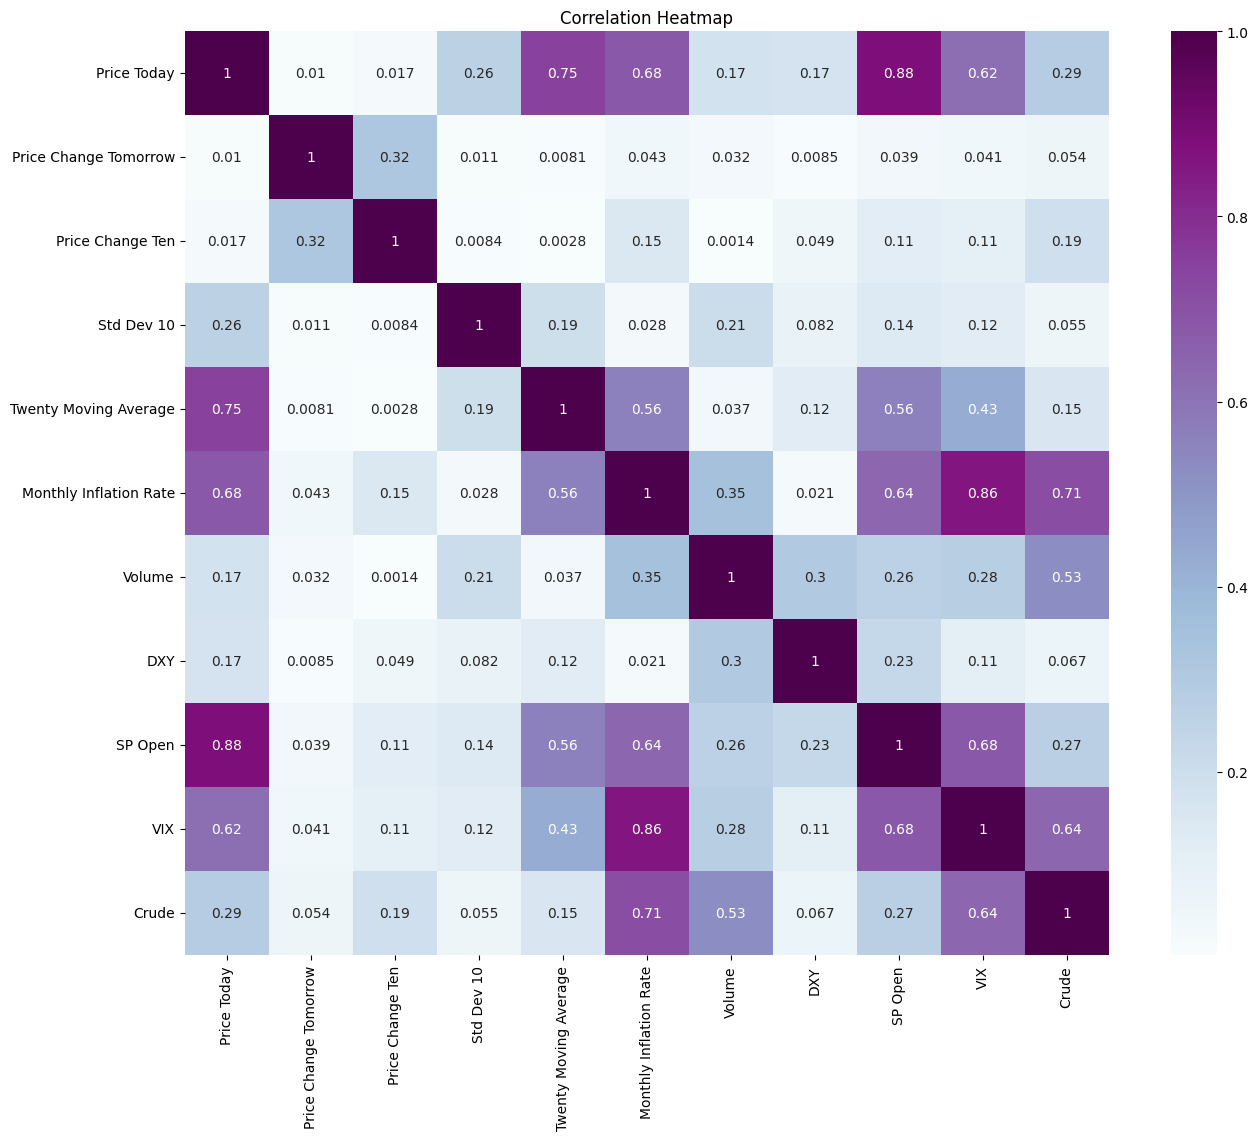

In [15]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr, square=True, annot=True, cmap='BuPu')
plt.title('Correlation Heatmap')
plt.show()

### Основные выводы: 
Удаляем следующие признаки: 

1. 'Price 2 Days Prior' - производная от цены сегодня
2. 'Price 1 Day Prior' - производная от цены сегодня
3. 'Price Change Tomorrow' - целевая переменная, будем  использовать Price Tomorrow
4. 'EFFR Rate' - сильная корреляция с Monthly Inflation Rate и меньшая корреляция с целевой переменной 
5. 'Treasury Par Yield Two Year' - производная от Treasury Par Yield Month
6. 'Treasury Par Yield Curve Rates (10 Yr)' - производная от Treasury Par Yield Month
7. 'Fifty Day Moving Average' - производная от Twenty Moving Average
8. '200 Day Moving Average' - производная от Twenty Moving Average
9. 'Treasury Par Yield Month' - сильная корреляция с Monthly Inflation Rate
10. 'Price Change Ten' - не можем использовать в предсказании(бессмысленно использовать для предсказания завтрашней цены цену, которая будет ч/з 10 дней)

## 1.4. Проведём более глубокий анализ признаков по-отдельности и попарно

#### Выбор пар признаков с высокой корреляцией

Для анализа выберем пары признаков, корреляция между которыми превышает заданный порог, например, 0.85 (85%).

In [16]:
high_corr_pairs = {}
threshold = 0.65

for col in corr.columns:
    for row in corr.index:
        if (corr.loc[row, col] > threshold) and (row != col):
            if (col, row) not in high_corr_pairs and (row, col) not in high_corr_pairs:
                high_corr_pairs[(row, col)] = corr.loc[row, col]


for pair, corr_value in high_corr_pairs.items():
    print(f"{pair}: {corr_value}")


('Twenty Moving Average', 'Price Today'): 0.7494671677603962
('Monthly Inflation Rate', 'Price Today'): 0.6806081482024733
('SP Open', 'Price Today'): 0.8802745798499555
('VIX', 'Monthly Inflation Rate'): 0.856990327096768
('Crude', 'Monthly Inflation Rate'): 0.7131503382928747
('VIX', 'SP Open'): 0.6815419887159996


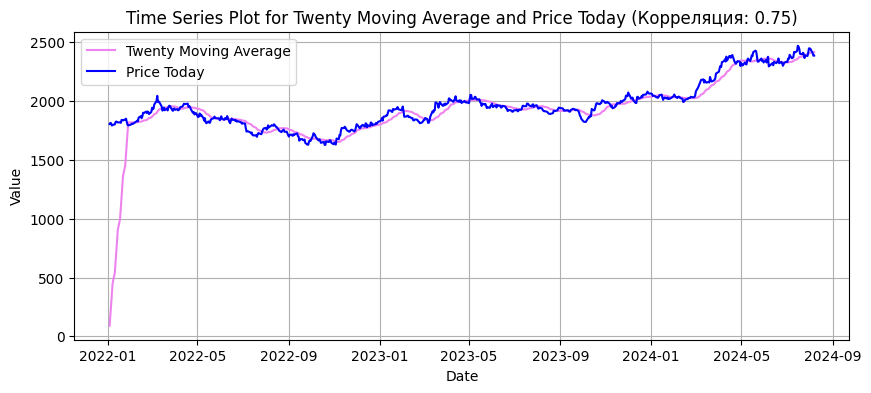

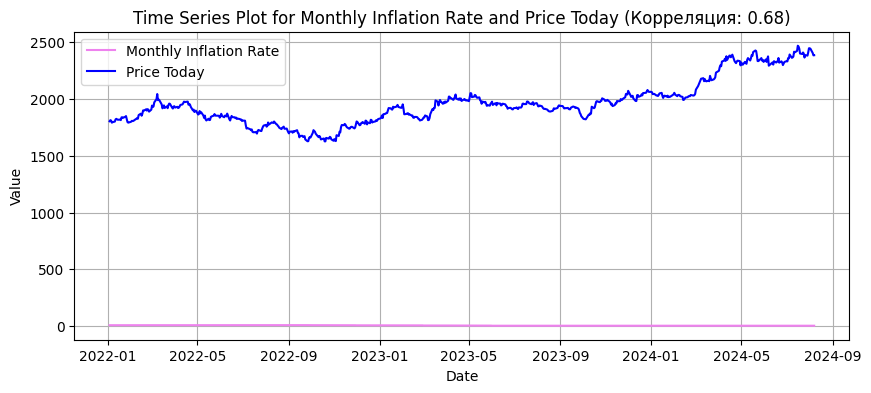

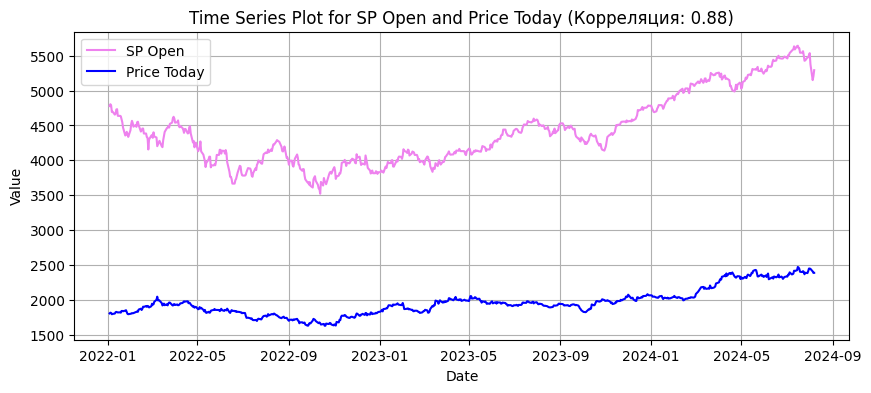

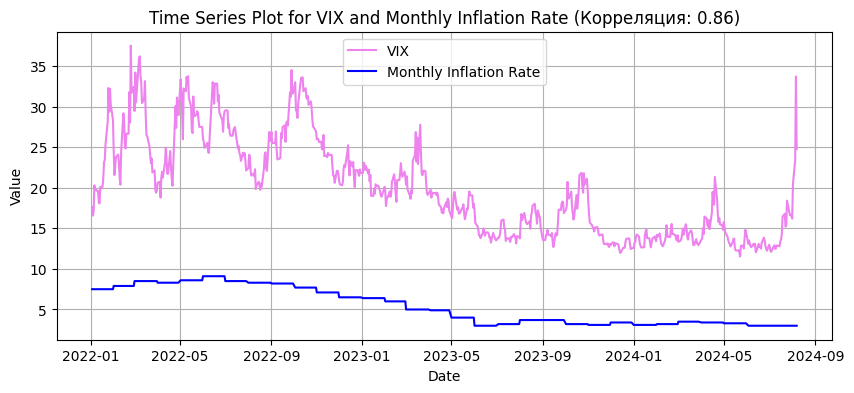

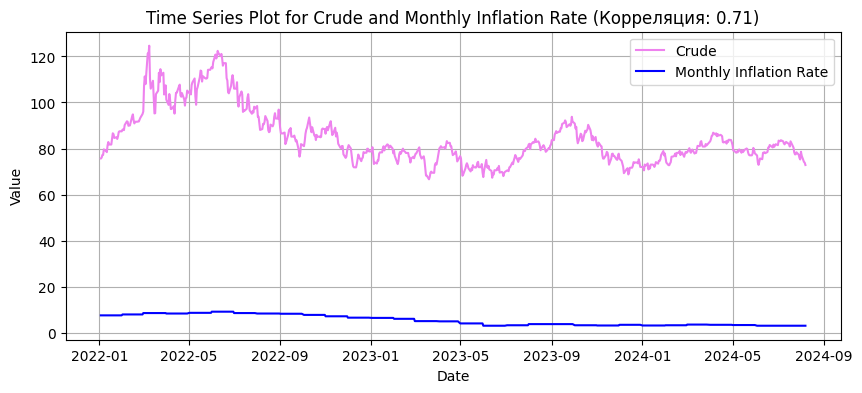

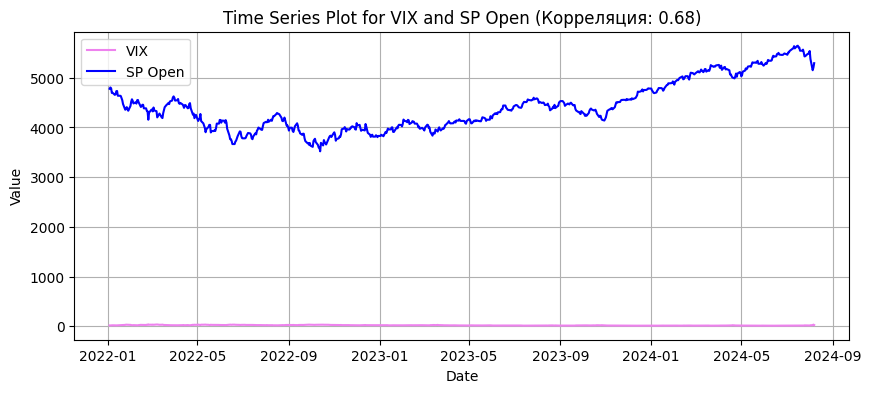

In [17]:

for pair in high_corr_pairs:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(data.index, data[pair[0]], label=pair[0], c = 'violet') 
    ax.plot(data.index, data[pair[1]], label=pair[1], c = 'b')
    plt.title(f"Time Series Plot for {pair[0]} and {pair[1]} (Корреляция: {high_corr_pairs[pair]:.2f})")
    plt.xlabel('Date')  
    plt.ylabel('Value')
    plt.legend()
    ax.grid(True)
    

Вывод: оставшиеся признаки либо не скореллированы, либо несут принципиально разную информацию, и выбрасывать их нельзя. Опционально можно рассматривать отношение признаков

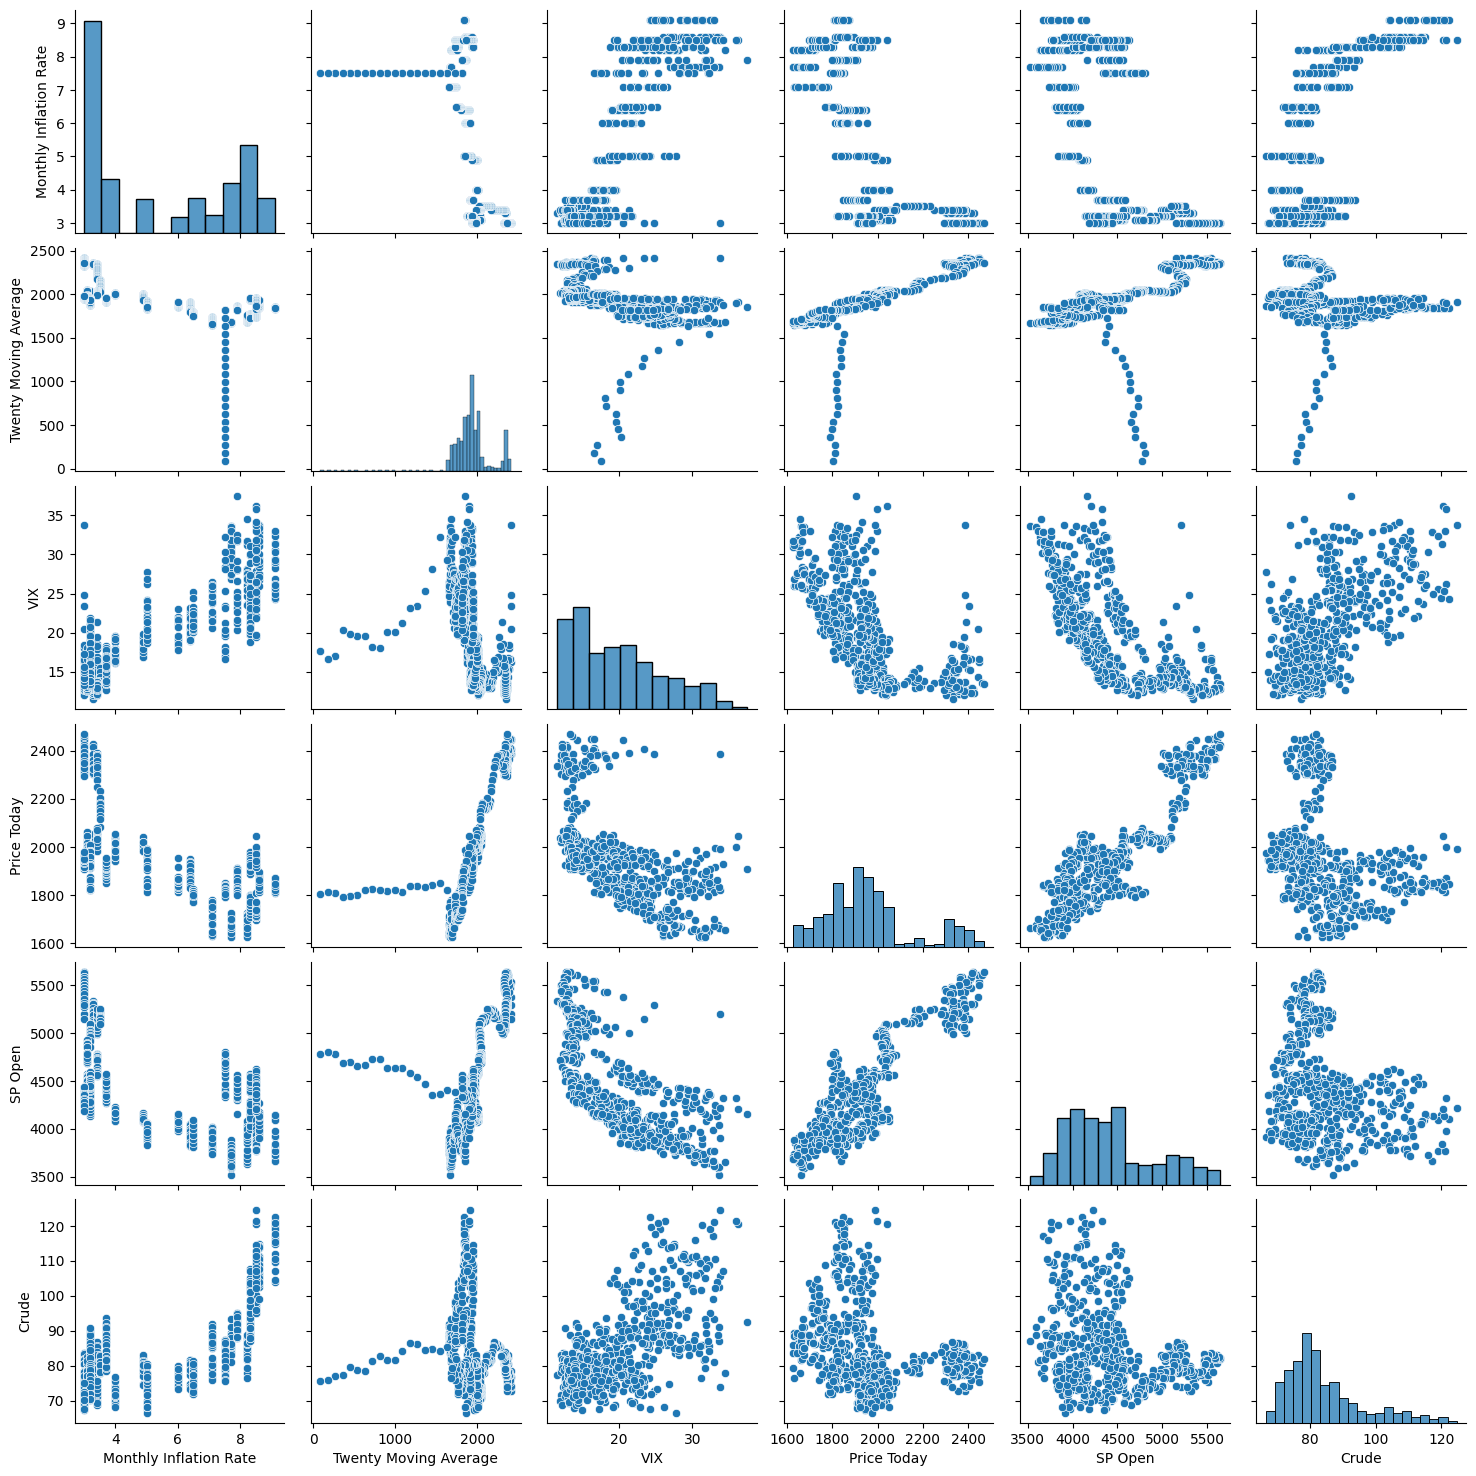

In [18]:
features = list(set([item for sublist in high_corr_pairs.keys() for item in sublist]))

sns.pairplot(data[features])
plt.show()


### Price Change Tomorrow
Как часто и насколько может меняться цена за несколько дней 

In [19]:
print(data['Price Change Tomorrow'].describe())
print(np.mean(abs((data['Price Change Tomorrow']))))

count    675.000000
mean       0.861570
std       17.531773
min      -81.890000
25%       -9.100000
50%        0.660000
75%       10.870000
max       66.660000
Name: Price Change Tomorrow, dtype: float64
13.126874074074074


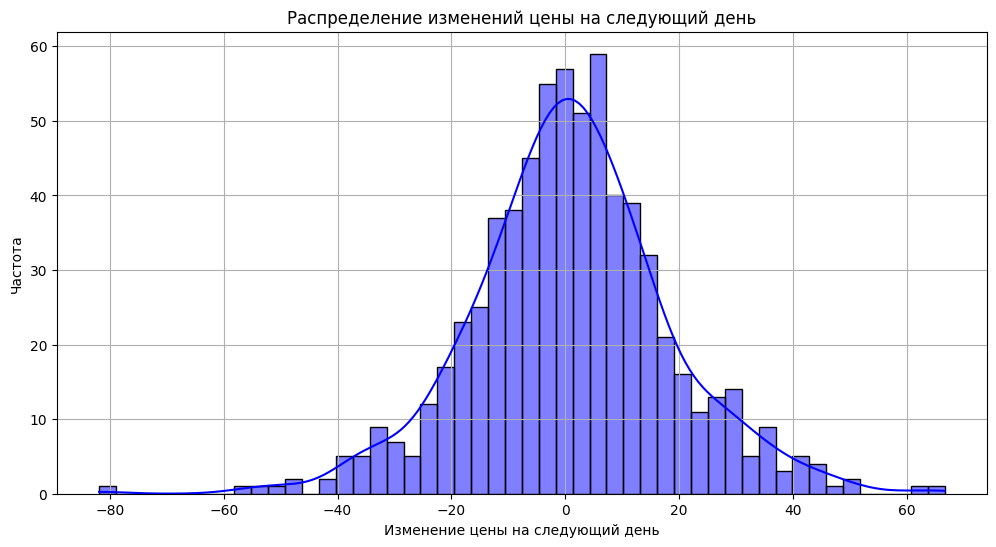

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Price Change Tomorrow'].dropna(), bins=50, kde=True, color='blue')
plt.title('Распределение изменений цены на следующий день')
plt.xlabel('Изменение цены на следующий день')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

### Основной вывод:
 - std  17.531773 
 - mean 13.126874074074074 
 
Следовательно, чтобы модель была достоверной, она должна обеспечивать точность не хуже этих

### Проверка наличия пропусков в данных

In [21]:
missing_data = data.isnull().sum()
print("Пропуски в данных по каждому признаку:")
print(missing_data[missing_data > 0])  

Пропуски в данных по каждому признаку:
Price Tomorrow            1
Price Change Tomorrow     1
Price Change Ten         10
Std Dev 10                9
dtype: int64


### Анализ обоснованности пропусков

Пропуски данных обоснованы в виду неимения завтрашней цены на золото

На всякий случай проверим, как считается  Std dev 10 - на 10 дней назад (формула)

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu)^2}$$


In [22]:
#data.loc['2024-07-20'] data.loc['2024-07-21'] - выходные дни - пропуски

In [23]:
start_date = '2023-07-17'
date_range = pd.date_range(start=start_date, periods=12, freq='D')
selected_data = data.reindex(date_range)
# Вычисление среднего значения
average_price = selected_data['Price Today'].mean()
print("Среднее значение по столбцу 'Price Today' за выбранный период: ", average_price)

Среднее значение по столбцу 'Price Today' за выбранный период:  1964.377


In [24]:
avg_all = data['Price Today'].mean()
avg_all

1957.937943786982

In [25]:
# Расчёт отклонения от среднего для каждого дня
selected_data['dev'] = abs(selected_data['Price Today'] - average_price)
selected_data.dropna(inplace = True)
selected_data['dev']

2023-07-17     8.877
2023-07-18    13.203
2023-07-19    13.413
2023-07-20     7.843
2023-07-21     2.527
2023-07-24     9.837
2023-07-25     1.063
2023-07-26     7.733
2023-07-27    16.887
2023-07-28     5.127
Name: dev, dtype: float64

In [26]:
std_dev = np.sqrt(sum(el**2 for el in selected_data['dev'])/9)
std_dev

10.382035820482292

In [27]:
std_dev_real = data.loc['2023-07-28']['Std Dev 10']
std_dev_real

10.38203582

нормуль, совпало

# 2. Подготовка данных

In [28]:
data.head(5)

,Price 2 Days Prior,Price 1 Day Prior,Price Today,Price Tomorrow,Price Change Tomorrow,Price Change Ten,Std Dev 10,Twenty Moving Average,Fifty Day Moving Average,200 Day Moving Average,Monthly Inflation Rate,EFFR Rate,Volume,Treasury Par Yield Month,Treasury Par Yield Two Year,Treasury Par Yield Curve Rates (10 Yr),DXY,SP Open,VIX,Crude
Date,,,,,,,,,,,,,,,,,,,,
2024-08-07,2405.87,2384.90,2385.83,NaN,NaN,NaN,30.155078,2414.7450,2368.2948,2189.80780,3.0,5.33,96,5.50,4.00,3.96,103.37,5293.13,24.77,72.84
2024-08-06,2442.74,2405.87,2384.90,2385.83,0.93,NaN,29.423936,2414.1525,2367.7916,2187.85630,3.0,5.33,89,5.50,3.99,3.90,102.78,5206.42,33.71,73.86
2024-08-05,2447.17,2442.74,2405.87,2384.90,-20.97,NaN,28.341301,2413.2305,2367.1584,2185.96345,3.0,5.33,86,5.52,3.89,3.78,103.22,5151.14,23.39,74.21
2024-08-02,2447.23,2447.17,2442.74,2405.87,-36.87,NaN,28.616661,2411.0920,2365.7250,2183.85640,3.0,5.33,89,5.54,3.88,3.80,104.31,5376.63,20.52,76.87
2024-08-01,2411.09,2447.23,2447.17,2442.74,-4.43,NaN,26.084796,2408.5670,2363.5624,2181.55785,3.0,5.33,83,5.55,4.16,3.99,104.07,5537.84,16.20,78.59


## Переходим к относительной целевой переменной

Это делается для того, чтобы масштаб переменных был порядка единицы + логарифм для того, чтобы сделать рост положительным, а снижение - отрицательным

In [29]:
data_for_train = data.copy()

data_for_train['Return Today'] = np.log(data_for_train['Price Today'] / data_for_train['Price 1 Day Prior'])
data_for_train['Return 1 Day Prior'] = np.log(data_for_train['Price 1 Day Prior'] / data_for_train['Price 2 Days Prior'])

# Target variable
data_for_train['Return Tomorrow'] = np.log(data_for_train['Price Tomorrow'] / data_for_train['Price Today'])

data_for_train.head()

,Price 2 Days Prior,Price 1 Day Prior,Price Today,Price Tomorrow,Price Change Tomorrow,Price Change Ten,Std Dev 10,Twenty Moving Average,Fifty Day Moving Average,200 Day Moving Average,...,Treasury Par Yield Month,Treasury Par Yield Two Year,Treasury Par Yield Curve Rates (10 Yr),DXY,SP Open,VIX,Crude,Return Today,Return 1 Day Prior,Return Tomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-07,2405.87,2384.90,2385.83,NaN,NaN,NaN,30.155078,2414.7450,2368.2948,2189.80780,...,5.50,4.00,3.96,103.37,5293.13,24.77,72.84,0.000390,-0.008754,NaN
2024-08-06,2442.74,2405.87,2384.90,2385.83,0.93,NaN,29.423936,2414.1525,2367.7916,2187.85630,...,5.50,3.99,3.90,102.78,5206.42,33.71,73.86,-0.008754,-0.015209,0.000390
2024-08-05,2447.17,2442.74,2405.87,2384.90,-20.97,NaN,28.341301,2413.2305,2367.1584,2185.96345,...,5.52,3.89,3.78,103.22,5151.14,23.39,74.21,-0.015209,-0.001812,-0.008754
2024-08-02,2447.23,2447.17,2442.74,2405.87,-36.87,NaN,28.616661,2411.0920,2365.7250,2183.85640,...,5.54,3.88,3.80,104.31,5376.63,20.52,76.87,-0.001812,-0.000025,-0.015209
2024-08-01,2411.09,2447.23,2447.17,2442.74,-4.43,NaN,26.084796,2408.5670,2363.5624,2181.55785,...,5.55,4.16,3.99,104.07,5537.84,16.20,78.59,-0.000025,0.014878,-0.001812


In [30]:
data_for_train = data_for_train.drop(['Price 2 Days Prior', 'Price 1 Day Prior', 'Price Change Tomorrow', 'Price Tomorrow', 'EFFR Rate', 'Treasury Par Yield Two Year', 'Treasury Par Yield Curve Rates (10 Yr)', 'Fifty Day Moving Average', '200 Day Moving Average', 'Treasury Par Yield Month', 'Price Change Ten'], axis = 1)

In [31]:
data_for_train

,Price Today,Std Dev 10,Twenty Moving Average,Monthly Inflation Rate,Volume,DXY,SP Open,VIX,Crude,Return Today,Return 1 Day Prior,Return Tomorrow
Date,,,,,,,,,,,,
2024-08-07,2385.83,30.155078,2414.7450,3.0,96,103.37,5293.13,24.77,72.84,0.000390,-0.008754,NaN
2024-08-06,2384.90,29.423936,2414.1525,3.0,89,102.78,5206.42,33.71,73.86,-0.008754,-0.015209,0.000390
2024-08-05,2405.87,28.341301,2413.2305,3.0,86,103.22,5151.14,23.39,74.21,-0.015209,-0.001812,-0.008754
2024-08-02,2442.74,28.616661,2411.0920,3.0,89,104.31,5376.63,20.52,76.87,-0.001812,-0.000025,-0.015209
2024-08-01,2447.17,26.084796,2408.5670,3.0,83,104.07,5537.84,16.20,78.59,-0.000025,0.014878,-0.001812
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,1796.41,NaN,450.8225,7.5,71,96.26,4697.66,19.85,79.62,0.002676,-0.010367,0.002841
2022-01-06,1791.61,NaN,361.0020,7.5,73,96.20,4693.39,20.29,77.24,-0.010367,-0.001987,0.002676
2022-01-05,1810.28,NaN,271.4215,7.5,74,96.31,4787.99,17.07,77.18,-0.001987,0.005312,-0.010367


In [32]:
data_for_train = data_for_train.dropna()
data_for_train.isnull().sum()

Price Today               0
Std Dev 10                0
Twenty Moving Average     0
Monthly Inflation Rate    0
Volume                    0
DXY                       0
SP Open                   0
VIX                       0
Crude                     0
Return Today              0
Return 1 Day Prior        0
Return Tomorrow           0
dtype: int64

In [33]:
data_for_train = data_for_train.astype(float)

In [34]:
data_for_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 666 entries, 2024-08-06 to 2022-01-14
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price Today             666 non-null    float64
 1   Std Dev 10              666 non-null    float64
 2   Twenty Moving Average   666 non-null    float64
 3   Monthly Inflation Rate  666 non-null    float64
 4   Volume                  666 non-null    float64
 5   DXY                     666 non-null    float64
 6   SP Open                 666 non-null    float64
 7   VIX                     666 non-null    float64
 8   Crude                   666 non-null    float64
 9   Return Today            666 non-null    float64
 10  Return 1 Day Prior      666 non-null    float64
 11  Return Tomorrow         666 non-null    float64
dtypes: float64(12)
memory usage: 67.6 KB


В соответствии с пунктом 1.2. нормируем данные

In [35]:
STDscalerVol = StandardScaler()
STDscalerDXY = StandardScaler()
MMscalerSTD = MinMaxScaler()
MMscalerMIR = MinMaxScaler()
MMscalerVIX = MinMaxScaler()

In [36]:
data_for_train.loc[:, 'Std Dev 10'] = MMscalerSTD.fit_transform(data_for_train[['Std Dev 10']])
data_for_train.loc[:, 'Monthly Inflation Rate'] = MMscalerMIR.fit_transform(data_for_train[['Monthly Inflation Rate']])
medTMA = np.median(data_for_train['Twenty Moving Average'])
data_for_train.loc[:, 'Twenty Moving Average'] = data_for_train['Twenty Moving Average'] / medTMA
data_for_train.loc[:, 'Volume'] = STDscalerVol.fit_transform(data_for_train[['Volume']])
data_for_train.loc[:, 'DXY'] = STDscalerDXY.fit_transform(data_for_train[['DXY']])
data_for_train.loc[:, 'SP Open'] = data_for_train['SP Open'] / data_for_train['SP Open'].shift(1)
data_for_train.loc[:, 'Crude'] = data_for_train['Crude'] / data_for_train['Crude'].shift(1)
data_for_train.loc[:, 'VIX'] = MMscalerVIX.fit_transform(data_for_train[['VIX']])

In [37]:
data_for_train.head()

,Price Today,Std Dev 10,Twenty Moving Average,Monthly Inflation Rate,Volume,DXY,SP Open,VIX,Crude,Return Today,Return 1 Day Prior,Return Tomorrow
Date,,,,,,,,,,,,
2024-08-06,2384.90,0.421171,1.251790,0.0,-0.386426,-0.351463,NaN,0.854062,NaN,-0.008754,-0.015209,0.000390
2024-08-05,2405.87,0.402042,1.251312,0.0,-0.580513,-0.219703,0.989382,0.456681,1.004739,-0.015209,-0.001812,-0.008754
2024-08-02,2442.74,0.406907,1.250203,0.0,-0.386426,0.106702,1.043775,0.346169,1.035844,-0.001812,-0.000025,-0.015209
2024-08-01,2447.17,0.362172,1.248894,0.0,-0.774600,0.034833,1.029983,0.179823,1.022375,-0.000025,0.014878,-0.001812
2024-07-31,2447.23,0.348432,1.246579,0.0,-1.098078,0.142636,0.994176,0.197536,0.957374,0.014878,0.011941,-0.000025


In [38]:
data_for_train = data_for_train.dropna()

In [39]:
y = data_for_train['Return Tomorrow']
X = data_for_train.drop(['Return Tomorrow', 'Price Today'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Для отношения

In [41]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Root Mean Squared Error: 0.009434230971616884
Mean Absolute Error: 0.0073662116873336155


 ## Для абсолютных значений

In [42]:
def metrics(X_test, y_pred):
    price_tomorrow = data['Price Tomorrow'][X_test.index]
    price_today = data['Price Today'][X_test.index]
    mse = mean_squared_error(price_tomorrow, np.exp(y_pred)*price_today)
    rmse = mse ** 0.5
    print(f'Root Mean Squared Error: {rmse}')

    mae = mean_absolute_error(price_tomorrow, np.exp(y_pred)*price_today)
    print(f'Mean Absolute Error: {mae}')
    
metrics(X_test, y_pred)

Root Mean Squared Error: 17.832246103799072
Mean Absolute Error: 13.832423014305242


## Регуляризация

In [43]:
modelLasso = Lasso()
modelLasso.fit(X_train, y_train)
y_pred = modelLasso.predict(X_test)

metrics(X_test, y_pred)

Root Mean Squared Error: 17.691959272246084
Mean Absolute Error: 13.39215137103687


In [44]:
modelLasso.coef_

array([ 0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0.])

как видим, L1 регуляризация "отбирает" признаки. Важных признаков не обнаружено)

In [45]:
modelRidge = Ridge()
modelRidge.fit(X_train, y_train)
y_pred = modelRidge.predict(X_test)

metrics(X_test, y_pred)

Root Mean Squared Error: 17.641808045169906
Mean Absolute Error: 13.56642648895397


In [46]:
y_pred

array([ 7.79571066e-04,  4.70313242e-04,  6.09740016e-04,  7.64207257e-04,
        4.07151790e-04,  3.51522143e-06,  2.80712314e-04,  7.74710473e-05,
        5.28801601e-04,  4.47997265e-05, -3.96980623e-04, -2.56855261e-04,
       -2.23572658e-04,  7.04467025e-04, -3.58725752e-04, -8.97368230e-04,
       -5.11395847e-04, -3.89062533e-04, -1.89474469e-04, -4.03112228e-04,
        6.61632232e-04,  2.47420695e-04, -4.31596431e-04, -5.40283262e-05,
       -2.12029479e-04, -8.83223558e-06,  7.53431770e-05, -1.46497031e-04,
       -3.45362396e-04, -2.05154924e-04, -2.90282222e-04, -6.26208308e-04,
       -5.78756300e-04, -3.31740949e-04, -7.52803601e-04, -5.88772217e-05,
       -1.60738058e-05, -1.73338861e-04, -3.78022127e-05, -4.71770795e-04,
       -3.68518642e-04, -1.85488325e-04, -2.71653183e-04,  2.90087080e-04,
        1.44280304e-05,  1.63557587e-04,  9.25524153e-06,  8.29918671e-05,
       -1.23138889e-04, -4.40390194e-05,  1.24421072e-05, -3.01113795e-04,
       -4.28154773e-04, -

In [47]:
modelElasticNet = ElasticNet()
modelElasticNet.fit(X_train, y_train)
y_pred = modelElasticNet.predict(X_test)

metrics(X_test, y_pred)

Root Mean Squared Error: 17.691959272246084
Mean Absolute Error: 13.39215137103687


In [48]:
modelElasticNet.coef_

array([ 0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0.])

In [49]:
modelElasticNetCV = ElasticNetCV()
modelElasticNetCV.fit(X_train, y_train)
y_pred = modelElasticNetCV.predict(X_test)

metrics(X_test, y_pred)

#работает, но хуже, чем ридж

Root Mean Squared Error: 17.795698728971345
Mean Absolute Error: 13.38868475260212


In [50]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

## Выводы:
Лучшие значения метрик (после подбора параметра регуляризации) 
  - Root Mean Squared Error: 17.641808045169906
  - Mean Absolute Error: 13.56642648895397
  
Как видно в пункте 1.4., модель работает на уровне случайного угадывания

# 3. Предсказание

 p.s.  -  все данные(величина признаков, цена) беру с сайтов, указанных на кагле - usagold  и тд
    за сентябрь на сайтах с данными нет monthly infation rate(по понятным причинам), поэтому взяла с августа, Volume на 27 сентября недоступен, взяла на 26
    
<img src=Screenshot.png> </img>  


берём ридж на основе всего, что попробовали выше(l2)

In [51]:
finModel = Ridge()
finModel.fit(X, y)
finModel.coef_

array([ 0.00028982, -0.00834719, -0.00255263, -0.00085383,  0.00030379,
       -0.00532948, -0.00135094,  0.00082841, -0.00147261, -0.00360355])

Нормируем новые данные по параметрам, полученным из обучающей выборки

In [52]:
def prepare_input(input_):
    input_.loc[:, 'Std Dev 10'] = MMscalerSTD.transform(input_[['Std Dev 10']])
    input_.loc[:, 'Monthly Inflation Rate'] = MMscalerMIR.transform(input_[['Monthly Inflation Rate']])
    input_.loc[:, 'Twenty Moving Average'] = input_['Twenty Moving Average'] / medTMA
    input_.loc[:, 'Volume'] = STDscalerVol.transform(input_[['Volume']])
    input_.loc[:, 'DXY'] = STDscalerDXY.transform(input_[['DXY']])
    input_.loc[:, 'VIX'] = MMscalerVIX.transform(input_[['VIX']])
    return input_

In [53]:
def l_to_fl(l): return float(l[0])

## 3.1. Какая была цена на золото 20 декабря 2021 года и сравнить с историческими данными.


In [54]:
x_test_17_dec = [{'Std Dev 10': 8.438, 'Twenty Moving Average': 1785.651, 'Monthly Inflation Rate': 7,  
                  'Volume': 71,  'DXY': 96.57, 'SP Open': 0.9859,  'VIX': 20.7, 'Crude': 1.006156, 
                  'Return Today': 0.99964, 'Return 1 Day Prior': 1.0107}]
price_17_dec = [1798.19]
price_20_dec = [1791.35]
x_test_17_dec = pd.DataFrame(x_test_17_dec, dtype=float)
x_test_17_dec = prepare_input(x_test_17_dec)

print(x_test_17_dec)

y_pred_20_dec = np.exp(finModel.predict(x_test_17_dec))

print((f'Предсказанное отношение цен на 20 декабря {y_pred_20_dec}'))
print(f'Реальное отношение цен на 20 декабря {l_to_fl(price_20_dec)/l_to_fl(price_17_dec)}')

print(f'Предсказанная цена на 20 декабря {y_pred_20_dec*price_17_dec}')
print(f'Реальная цена на 20 декабря {price_20_dec}')

print(f'Root Mean Squared Error: {mean_squared_error(price_20_dec, (y_pred_20_dec)*price_17_dec)** 0.5}')

print(f'Mean Absolute Error: {mean_absolute_error(price_20_dec, (y_pred_20_dec)*price_17_dec)}')

   Std Dev 10  Twenty Moving Average  Monthly Inflation Rate    Volume  \
0    0.050371               0.925898                0.655738 -1.550948   

        DXY  SP Open     VIX     Crude  Return Today  Return 1 Day Prior  
0 -2.211074   0.9859  0.3531  1.006156       0.99964              1.0107  
Предсказанное отношение цен на 20 декабря [0.99593475]
Реальное отношение цен на 20 декабря 0.9961961750426818
Предсказанная цена на 20 декабря [1790.87990169]
Реальная цена на 20 декабря [1791.35]
Root Mean Squared Error: 0.47009831415562076
Mean Absolute Error: 0.47009831415562076


## 3.2. Также спрогнозировать, какая цена была на золото 8 августа 2024 года и сравнить с историческими данными.

In [55]:
x_test_7_aug = [{'Std Dev 10': 30.155, 'Twenty Moving Average': 2414.745, 'Monthly Inflation Rate': 3,  
                  'Volume': 96,  'DXY': 103.2, 'SP Open': 1.0167,  'VIX': 24.77, 'Crude': 0.986, 
                  'Return Today': 1.0004, 'Return 1 Day Prior': 0.9913}]
price_7_aug = [2385.83]
price_8_aug = [2426.00]
x_test_7_aug = pd.DataFrame(x_test_7_aug, dtype=float)
x_test_7_aug = prepare_input(x_test_7_aug)
print(x_test_7_aug)
y_pred_8_aug = np.exp(finModel.predict(x_test_7_aug))

print((f'Предсказанное отношение цен на 20 декабря {y_pred_8_aug}'))
print(f'Реальное отношение цен на 20 декабря {l_to_fl(price_8_aug)/l_to_fl(price_7_aug)}')

print(f'Предсказанная цена на 8 августа{y_pred_8_aug*price_7_aug}')
print(f'Реальная цена на 8 августа{price_8_aug}')

print(f'Root Mean Squared Error: {mean_squared_error(price_8_aug, (y_pred_8_aug)*price_7_aug)** 0.5}')

print(f'Mean Absolute Error: {mean_absolute_error(price_8_aug, (y_pred_8_aug)*price_7_aug)}')

   Std Dev 10  Twenty Moving Average  Monthly Inflation Rate    Volume  \
0    0.434088               1.252097                     0.0  0.066444   

        DXY  SP Open       VIX  Crude  Return Today  Return 1 Day Prior  
0 -0.225692   1.0167  0.509819  0.986        1.0004              0.9913  
Предсказанное отношение цен на 20 декабря [0.99390571]
Реальное отношение цен на 20 декабря 1.0168369079104547
Предсказанная цена на 8 августа[2371.29007075]
Реальная цена на 8 августа[2426.0]
Root Mean Squared Error: 54.70992925251494
Mean Absolute Error: 54.70992925251494


## 3.3. Спрогнозировать цену для 30 сентября 2024 года и мы с вами в понедельник вместе оценим, насколько хорошо работает ваша модель для столь отдалённой даты. А также обсудим возможные причины отклонения предсказаний от реальных данных и методы улучшения работы модели.

In [56]:
x_test_27_sep = [{'Std Dev 10': 41.090328, 'Twenty Moving Average': 2570.0365, 'Monthly Inflation Rate': 2.5,  
                  'Volume': 100,  'DXY': 100.42, 'SP Open': 0.998809487,  'VIX': 15.64, 'Crude': 0.965087995, 
                  'Return Today': 0.994169478, 'Return 1 Day Prior': 1.005872284}]


price_27_sep = 2658.27
# price_30_sep = 
x_test_27_sep = pd.DataFrame(x_test_27_sep, dtype=float)
x_test_27_sep = prepare_input(x_test_27_sep)

print(x_test_27_sep)

y_pred_30_sep = np.exp(finModel.predict(x_test_27_sep))

print((f'Предсказанное отношение цен на 30 сентября{y_pred_30_sep}'))
#print(f'Реальное отношение цен на 20 декабря {l_to_fl(price_30_sep)/l_to_fl(price_27_sep)}')

print(f'Предсказанная цена на 30 сентября{y_pred_30_sep*price_27_sep}')
print(f'Реальная цена на 30 сентября - завтра и узнаем!')

# print(f'Root Mean Squared Error: {mean_squared_error(price_30_sep, (y_pred_30_sep)*price_27_sep)** 0.5}')

# print(f'Mean Absolute Error: {mean_absolute_error(price_30_sep, (y_pred_30_sep)*price_27_sep)}')

   Std Dev 10  Twenty Moving Average  Monthly Inflation Rate    Volume  \
0    0.627304               1.332619               -0.081967  0.325227   

        DXY   SP Open      VIX     Crude  Return Today  Return 1 Day Prior  
0 -1.058175  0.998809  0.15826  0.965088      0.994169            1.005872  
Предсказанное отношение цен на 30 сентября[0.9935369]
Предсказанная цена на 30 сентября[2641.08934562]
Реальная цена на 30 сентября - завтра и узнаем!


 Интересное примечание после экспериментирования:
 
 Попробовала предсказывать не отношение, а его логарифм, или, соответственно, экспоненту
 Как известно, экспонента смещает медиану на наших данных вправо, а логарифм - как раз влево, а лин. регрессия всё усредняет
 
 И соответсвенно, попробовав оба варианта, вот что получила:
 
 - обучаемся на экспоненте отношения - медиана вправо, модель оч хорошо предсказывает рост, в предсказании на 8 августа ошибки примерно НУЛЕВЫЕ, при этом на данных декабря, где спад цены в реальности - предсказывается небольшой рост и ошибки в районе 40
 - обучаемся на логарифме отношения - медиана влево, модель оч хорошо предсказывает спад цены, в предсказании на 20 декабря ошибки примерно НУЛЕВЫЕ, при этом на данных августа, где рост цены в реальности - предсказывается небольшой спад и ошибки в районе 40 - т.е. всё наоборот
 - регрессия предсказывает маленький разброс (все усредняется)

# 4. Предложения по поводу улучшения решения

1. Более сложные модели для работы с табличными данным, такие как RandomForest и CatBoost справляются еще хуже, что говорит о том, что проблема, скорее всего, именно в нехватке данных для принятия решения, а не в плохой модели.
2. Можно развить идею с логарифмом целевой переменной - Постановка вспомогательной задачи классификации для увеличения точности предсказания направления изменения цены (рост или падение)
3. Добавление признаков, например, индикатора конца недели (тк через выходные скачок цены больше, биржа не работает)
4. Построение модели по всем параметрам с разделением на 2 МЛ модели: предсказание тренда и предсказание колебаний, что позволит строить более точные и долгосрочные предсказания
5. Построение частотной модели для разделения тренда и колебаний
6. Переменные, которые меняются ступенькой по месяцам, как, например EFFR и Monthly Inflation хорошо бы сгладить на переходе между месяцами, чтобы не было перепадов
7. Учет исходного масштаба признаков и работа с процентами, а не отношением (увеличит разброс параметров и позволит предсказывать большие изменения)
8. Вместо удаления сильно коррелированных признаков можно нормировать на общий тренд и оставлять только колебания (устранение корреляции с сохранением данных)

In [57]:
#from sklearn.ensemble import RandomForestRegressor

#modelRandomForestRegressor = RandomForestRegressor()
#modelRandomForestRegressor.fit(X_train, y_train)

#y_pred = modelRandomForestRegressor.predict(X_test)

#metrics(X_test, y_pred)

In [58]:
#from catboost import CatBoostRegressor

#modelCatBoostRegressor = CatBoostRegressor()
#modelCatBoostRegressor.fit(X_train, y_train, verbose=False)

#y_pred = modelCatBoostRegressor.predict(X_test)

#metrics(X_test, y_pred)

## 5. SVM (SVR)

Применим SVR для предсказания стоимости золота и сравним с результатами, которые были
получены для линейной регрессии.

In [71]:
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit


In [113]:
Y = data_for_train['Return Tomorrow']
X = data_for_train.drop(['Return Tomorrow', 'Price Today'], axis=1)

In [114]:
X.shape, Y.shape

((665, 10), (665,))

In [64]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [65]:
X_reduced.shape, Y.shape

((665, 2), (665,))

Projecting 10-dimensional data to 2D


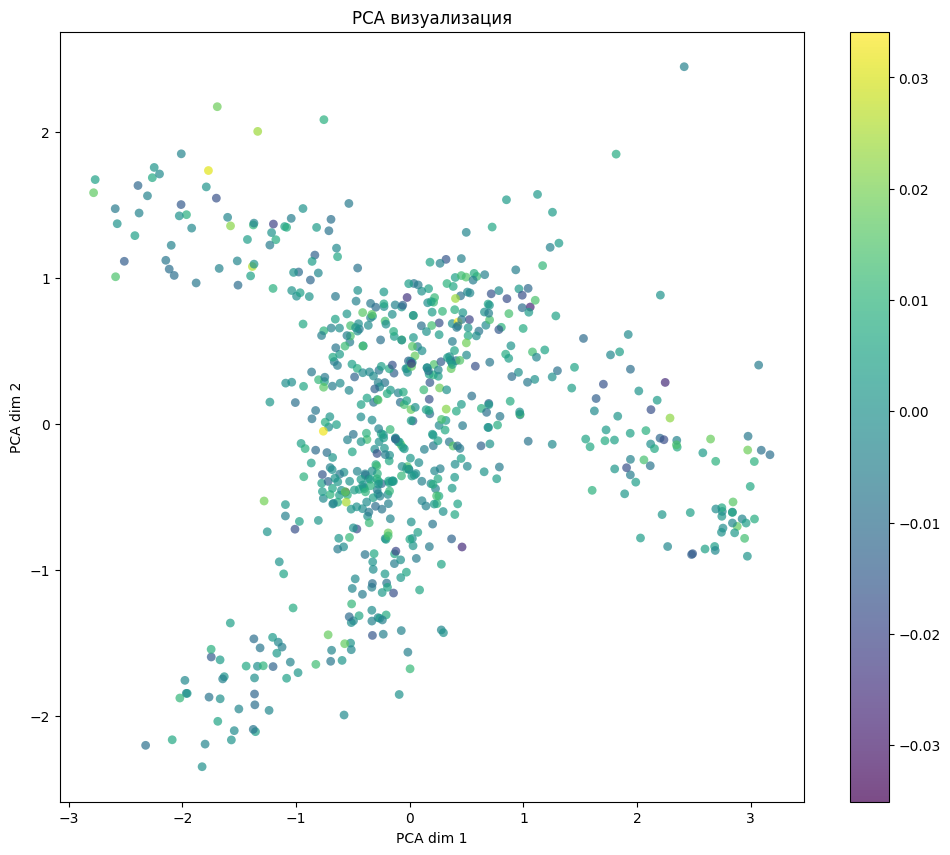

In [66]:
print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, edgecolor='none', alpha=0.7, s=40,
      cmap='viridis')
plt.title('PCA визуализация')
plt.xlabel('PCA dim 1')
plt.ylabel('PCA dim 2')
plt.colorbar()

plt.show()

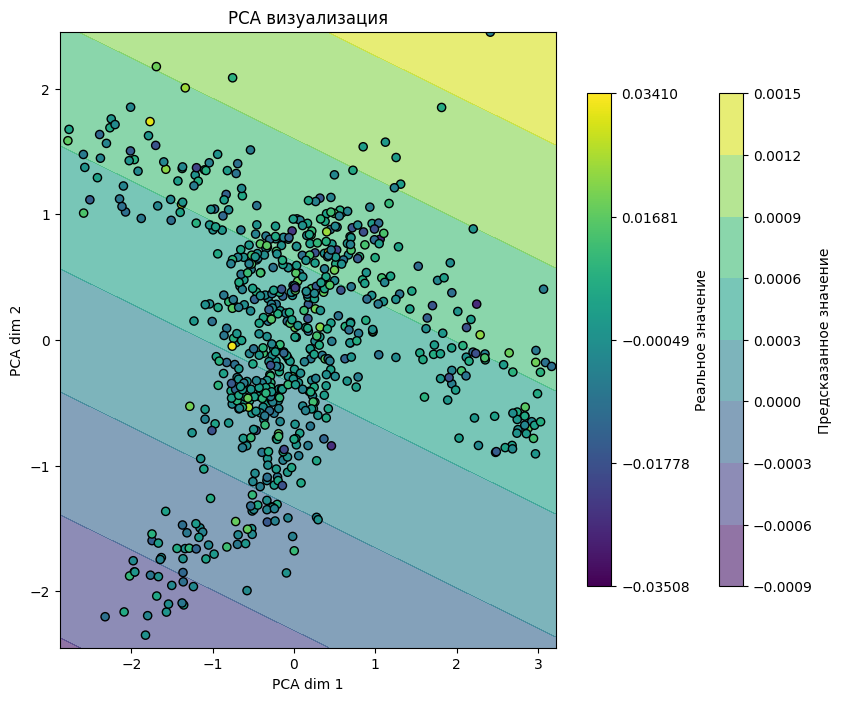

In [67]:
x1_min, x1_max = X_reduced[:, 0].min()-0.1, X_reduced[:, 0].max()+0.1
x2_min, x2_max = X_reduced[:, 1].min()-0.1, X_reduced[:, 1].max()+0.1 
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
           np.arange(x2_min, x2_max, 0.1))

grid_points = np.c_[xx1.ravel(), xx2.ravel()]

model = LinearRegression()
model.fit(X_reduced, Y)

predictions = model.predict(grid_points)

plt.figure(figsize=(10, 8))

plt.contourf(xx1, xx2, predictions.reshape(xx1.shape), cmap='viridis', alpha=0.6)
plt.colorbar(label='Предсказанное значение', shrink=0.8)


plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='viridis', edgecolors='k', s=35, alpha=1)
plt.xlabel('PCA dim 1')
plt.ylabel('PCA dim 2')
plt.title('PCA визуализация')
plt.colorbar(label='Реальное значение', shrink=0.8, ticks=np.linspace(Y.min(), Y.max(), 5))

plt.show()

In [116]:
len_g = len_c = 10
arr_beg = np.linspace(0.1, 0.9, len_c)
arr_end = np.linspace(1, 10, len_c)
arr = np.concatenate((arr_beg, arr_end), axis=0)
arr

array([ 0.1       ,  0.18888889,  0.27777778,  0.36666667,  0.45555556,
        0.54444444,  0.63333333,  0.72222222,  0.81111111,  0.9       ,
        1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
        6.        ,  7.        ,  8.        ,  9.        , 10.        ])

In [117]:
def print_cv_results(gs_obj, len_gs, param_r, param_sep):
    gs_params = gs_obj.get_params()
    category = len(gs_params['param_grid'][param_sep])
    metrics=gs_obj.cv_results_['mean_test_score'].reshape(len_gs, category)

    df=pd.DataFrame(metrics)

    pen_par=gs_params['param_grid'][param_sep]
    c_par=gs_params['param_grid'][param_r].tolist()
    columns_mapper=dict(zip(range(0, len(pen_par)),pen_par))
    row_mapper=dict(zip(range(0, len(c_par)), c_par))

    df.rename(columns=columns_mapper, index=row_mapper, inplace=True)

    plot = df.plot(title='Mean accuracy rating',grid=True)
    plot.set_xlabel(param_r, fontsize=13)
    plot.set_ylabel('acc', rotation=0, fontsize=13, labelpad=15)

In [118]:
svr = SVR(max_iter=100)

param_grid={
    'C': arr,
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

gs=GridSearchCV(svr,param_grid=param_grid, cv=5,
                n_jobs=-1, scoring='neg_mean_absolute_error', verbose=3)
gs.fit(X, Y);

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 3/5] END ................C=9.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 5/5] END ................C=9.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 4/5] END ............C=9.0, kernel=sigmoid;, score=-0.007 total time=   0.0s
[CV 4/5] END ............C=10.0, kernel=linear;, score=-0.007 total time=   0.0s
[CV 5/5] END ..............C=10.0, kernel=poly;, score=-0.007 total time=   0.0s
[CV 1/5] END ...........C=10.0, kernel=sigmoid;, score=-0.008 total time=   0.0s
[CV 4/5] END .............C=0.1, kernel=linear;, score=-0.007 total time=   0.0s
[CV 2/5] END ................C=0.1, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 5/5] END C=0.18888888888888888, kernel=linear;, score=-0.007 total time=   0.0s
[CV 1/5] END C=0.18888888888888888, kernel=poly;, score=-0.008 total time=   0.0s
[CV 1/5] END C=0.2777777777777778, kernel=linear;, score=-0.008 total time=   0.0s
[CV 2/5] END C=0.2777777777777778, kernel

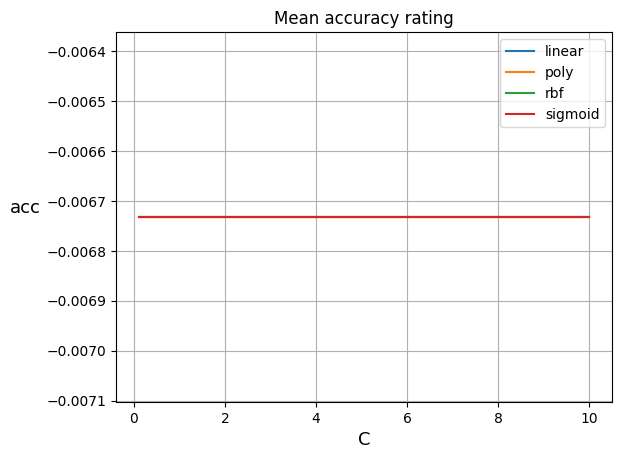

In [119]:
print_cv_results(gs, len(arr), 'C','kernel')

In [120]:
gs.cv_results_['mean_test_score']

array([-0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00673206,
       -0.00673206, -0.00673206, -0.00673206, -0.00673206, -0.00

Здесь мы видим такой же эффект, как у линейной регрессии с l1 регуляризацией. Зависимость в данных сущетсвенно сложнее, чем сложность модели, модель просто не может никак обучиться на этом всем и вытащить целевую зависимость из данных, поэтому, для того, чтобы минимизировать ошибку, она просто отвечает средним.

Модель недообучается

In [93]:
svr = SVR(max_iter=500)

len_g = len_c = 10
param_grid={
    'C': arr,
    'gamma': arr,
    'kernel': ['rbf', 'linear']
    }

gs=GridSearchCV(svr,param_grid=param_grid, cv=5,
                n_jobs=-1, scoring='neg_mean_absolute_error')
gs.fit(X, Y);

In [84]:
gs.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [85]:
gs.best_score_

-0.006732060129974626

[CV 2/5] END ...............C=0.1, kernel=poly;, score=-0.005 total time=   0.0s
[CV 1/5] END C=0.4555555555555556, kernel=linear;, score=-0.008 total time=   0.0s
[CV 2/5] END C=0.4555555555555556, kernel=linear;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.4555555555555556, kernel=linear;, score=-0.007 total time=   0.0s
[CV 4/5] END C=0.4555555555555556, kernel=linear;, score=-0.007 total time=   0.0s
[CV 4/5] END C=0.5444444444444445, kernel=poly;, score=-0.007 total time=   0.0s
[CV 5/5] END C=0.5444444444444445, kernel=poly;, score=-0.007 total time=   0.0s
[CV 1/5] END .C=0.5444444444444445, kernel=rbf;, score=-0.008 total time=   0.0s
[CV 2/5] END .C=0.5444444444444445, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 1/5] END C=0.7222222222222222, kernel=linear;, score=-0.008 total time=   0.0s
[CV 2/5] END C=0.7222222222222222, kernel=linear;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.7222222222222222, kernel=linear;, score=-0.007 total time=   0.0s
[CV 4/5] END C

[CV 3/5] END ................C=9.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 1/5] END ............C=9.0, kernel=sigmoid;, score=-0.008 total time=   0.0s
[CV 5/5] END ............C=9.0, kernel=sigmoid;, score=-0.007 total time=   0.0s
[CV 5/5] END ............C=10.0, kernel=linear;, score=-0.007 total time=   0.0s
[CV 5/5] END ..............C=10.0, kernel=poly;, score=-0.007 total time=   0.0s
[CV 4/5] END ...............C=10.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 4/5] END ...........C=10.0, kernel=sigmoid;, score=-0.007 total time=   0.0s
[CV 4/5] END .............C=0.1, kernel=linear;, score=-0.007 total time=   0.0s
[CV 1/5] END C=0.18888888888888888, kernel=poly;, score=-0.008 total time=   0.0s
[CV 2/5] END C=0.18888888888888888, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 4/5] END C=0.18888888888888888, kernel=sigmoid;, score=-0.007 total time=   0.0s
[CV 5/5] END C=0.2777777777777778, kernel=linear;, score=-0.007 total time=   0.0s
[CV 3/5] END .C=0.277

[CV 3/5] END ..............C=10.0, kernel=poly;, score=-0.007 total time=   0.0s
[CV 5/5] END ...............C=10.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 3/5] END ...............C=0.1, kernel=poly;, score=-0.007 total time=   0.0s
[CV 4/5] END C=0.6333333333333333, kernel=poly;, score=-0.007 total time=   0.0s
[CV 5/5] END C=0.6333333333333333, kernel=poly;, score=-0.007 total time=   0.0s
[CV 1/5] END .C=0.6333333333333333, kernel=rbf;, score=-0.008 total time=   0.0s
[CV 2/5] END .C=0.6333333333333333, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 1/5] END C=0.8111111111111111, kernel=linear;, score=-0.008 total time=   0.0s
[CV 2/5] END C=0.8111111111111111, kernel=linear;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.8111111111111111, kernel=linear;, score=-0.007 total time=   0.0s
[CV 4/5] END C=0.8111111111111111, kernel=linear;, score=-0.007 total time=   0.0s
[CV 5/5] END C=0.8111111111111111, kernel=linear;, score=-0.007 total time=   0.0s
[CV 1/5] END C=0.8

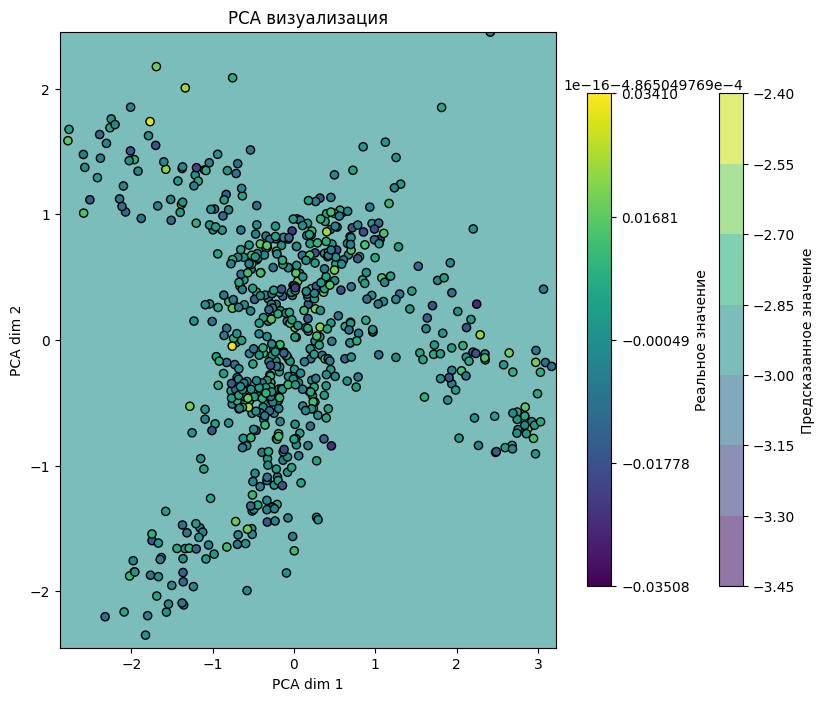

In [88]:
x1_min, x1_max = X_reduced[:, 0].min()-0.1, X_reduced[:, 0].max()+0.1
x2_min, x2_max = X_reduced[:, 1].min()-0.1, X_reduced[:, 1].max()+0.1 
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
           np.arange(x2_min, x2_max, 0.1))

grid_points = np.c_[xx1.ravel(), xx2.ravel()]

model = gs.best_estimator_
model.fit(X_reduced, Y)

predictions = model.predict(grid_points)

plt.figure(figsize=(10, 8))

plt.contourf(xx1, xx2, predictions.reshape(xx1.shape), cmap='viridis', alpha=0.6)
plt.colorbar(label='Предсказанное значение', shrink=0.8)


plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='viridis', edgecolors='k', s=35, alpha=1)
plt.xlabel('PCA dim 1')
plt.ylabel('PCA dim 2')
plt.title('PCA визуализация')
plt.colorbar(label='Реальное значение', shrink=0.8, ticks=np.linspace(Y.min(), Y.max(), 5))

plt.show()

In [89]:
params = model.get_params()
params

{'C': 0.1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': 500,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

[CV 4/5] END ...............C=8.0, kernel=poly;, score=-0.007 total time=   0.0s
[CV 5/5] END ...............C=8.0, kernel=poly;, score=-0.007 total time=   0.0s
[CV 1/5] END ................C=8.0, kernel=rbf;, score=-0.008 total time=   0.0s
[CV 2/5] END ................C=8.0, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 1/5] END ............C=10.0, kernel=linear;, score=-0.008 total time=   0.0s
[CV 2/5] END ..............C=10.0, kernel=poly;, score=-0.005 total time=   0.0s
[CV 3/5] END ...............C=10.0, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 3/5] END ...........C=10.0, kernel=sigmoid;, score=-0.007 total time=   0.0s


In [122]:
svr = SVR(max_iter=500)

len_g = len_c = 10
param_grid={
    'C': arr,
    'gamma': arr,
    'kernel': ['rbf', 'linear']
    }

gs=GridSearchCV(svr,param_grid=param_grid, cv=5,
                n_jobs=-1, scoring='neg_mean_absolute_error')
gs.fit(X, Y);

In [124]:
predictions = gs.predict(X)
predictions

array([-0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004865,
       -0.0004865, -0.0004865, -0.0004865, -0.0004865, -0.0004